# Computation of GRD patterns from gravity-toolkit

In [2]:
import sys
sys.path.append("/Users/dewilebars/Projects/gravity-toolkit/")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import gravity_toolkit as gravtk

In [3]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Read data from Frederikse et al. (2019)

In [4]:
Budget_data_dir = '/Users/dewilebars/Projects/SLBudget/data/'
Fred_dir = f'{Budget_data_dir}Frederikse2020/'
ais_ds = xr.open_dataset(Fred_dir + 'AIS.nc')
gis_ds = xr.open_dataset(Fred_dir + 'GrIS.nc')

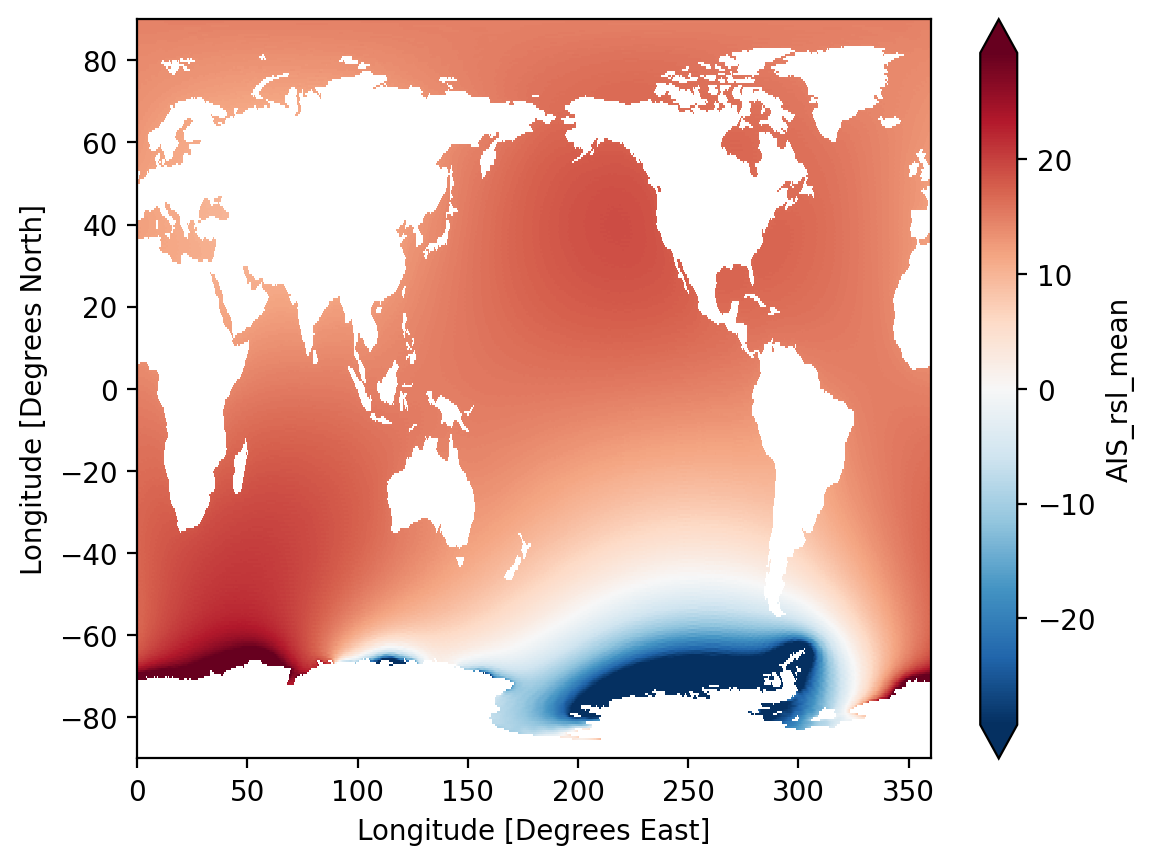

In [5]:
(ais_ds.AIS_rsl_mean.isel(time=-1)-ais_ds.AIS_rsl_mean.isel(time=1)).plot(robust=True)

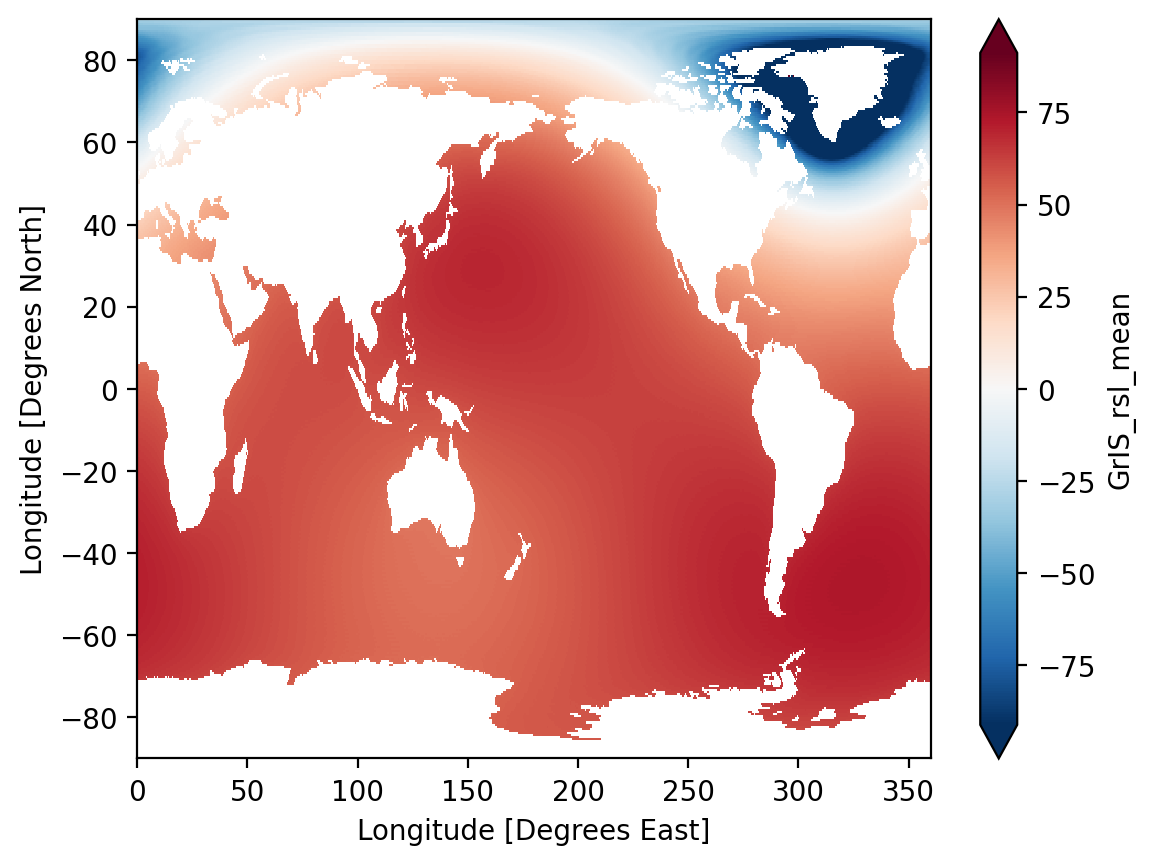

In [6]:
(gis_ds.GrIS_rsl_mean.isel(time=-1)-gis_ds.GrIS_rsl_mean.isel(time=1)).plot(robust=True)

In [7]:
Fred_unif_dir = f'{Budget_data_dir}fp_uniform/'

ais_unif_ds = xr.open_dataset(Fred_unif_dir + 'AIS.nc')

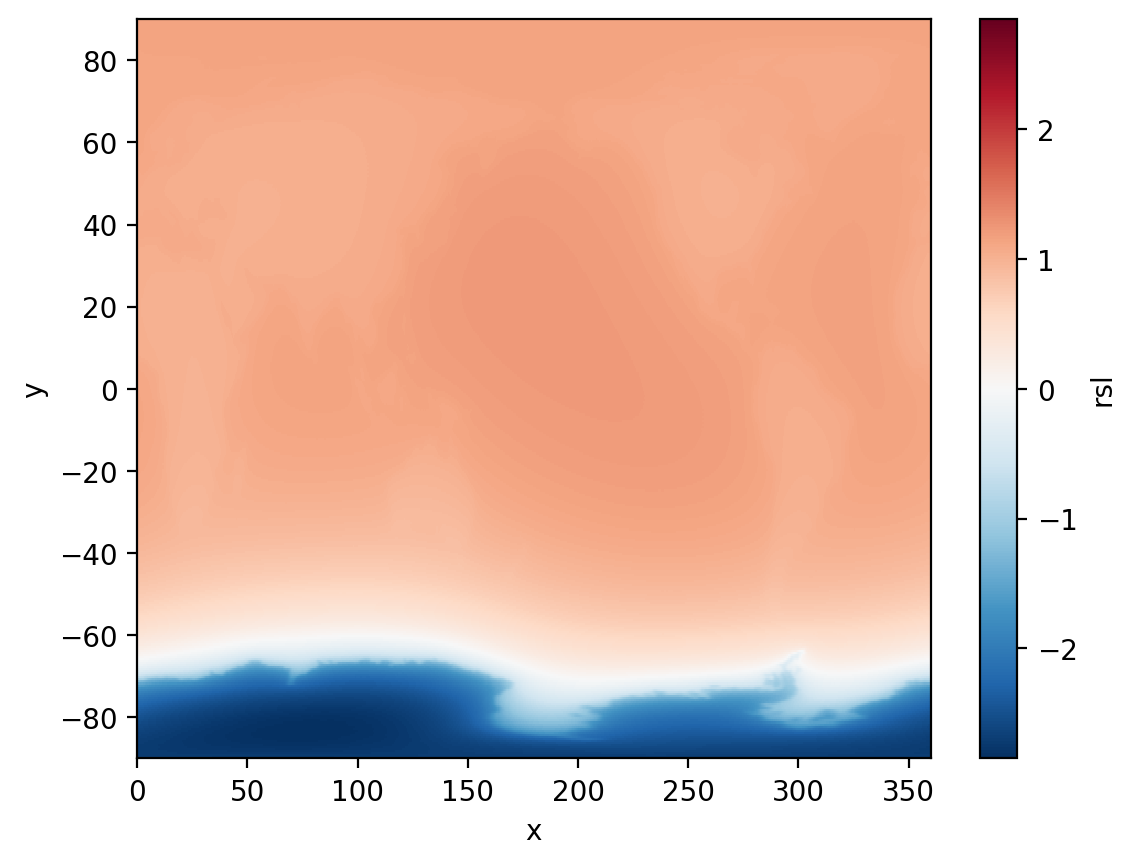

In [8]:
ais_unif_ds.rsl.plot()

Unfortunately the land is not masked. This makes it difficult to compute the global mean.

## Compute GRD patterns

### Define a load map

In [9]:
# Read reference mask
path_masks = '/Users/dewilebars/Projects/Project_ProbSLR/CMIP_SeaLevel/inputs/'
masks_ds = xr.open_dataset(f'{path_masks}reference_masks.nc')

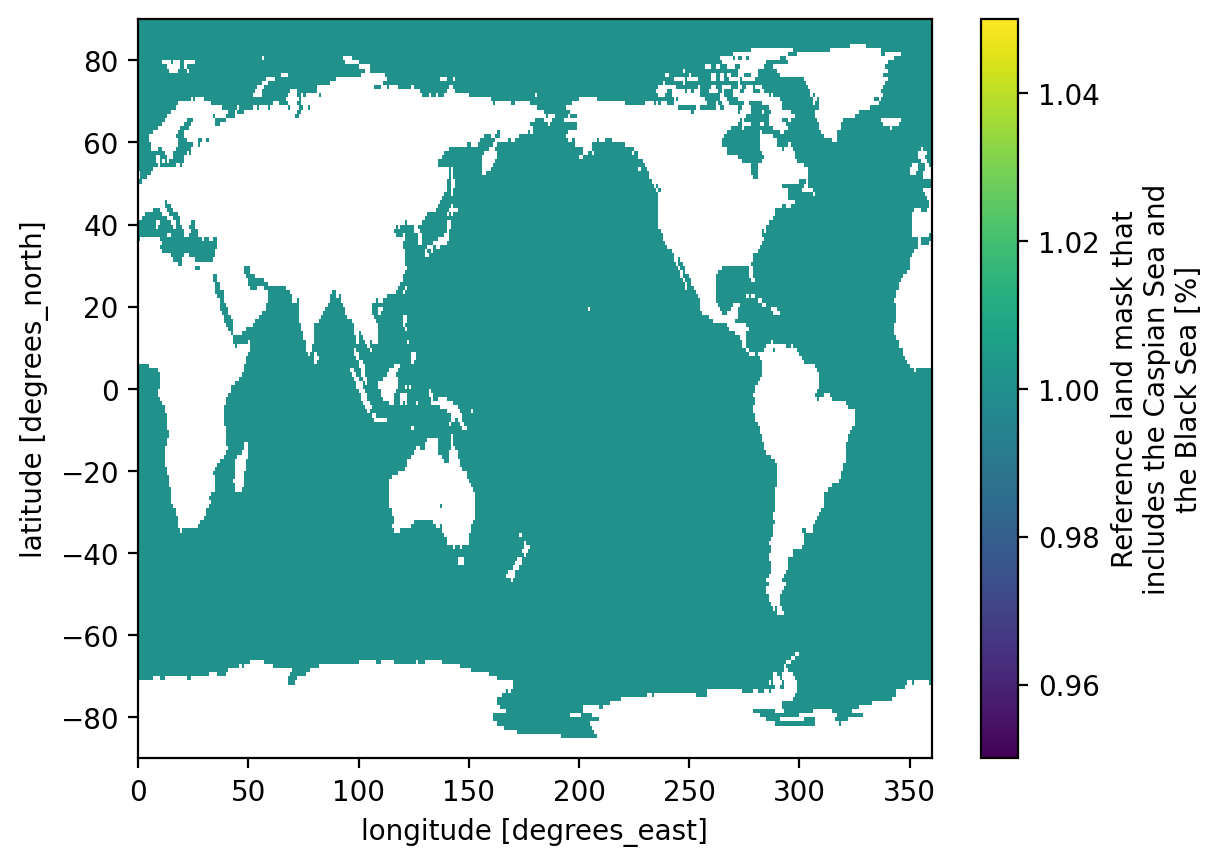

In [10]:
masks_ds.mask.plot()

In [11]:
landsea = xr.where(masks_ds.mask==1, 0, 1)
load_aa = xr.where(landsea.lat>=(-60),0, landsea)

load_aa = -load_aa # Negative values mean removed load

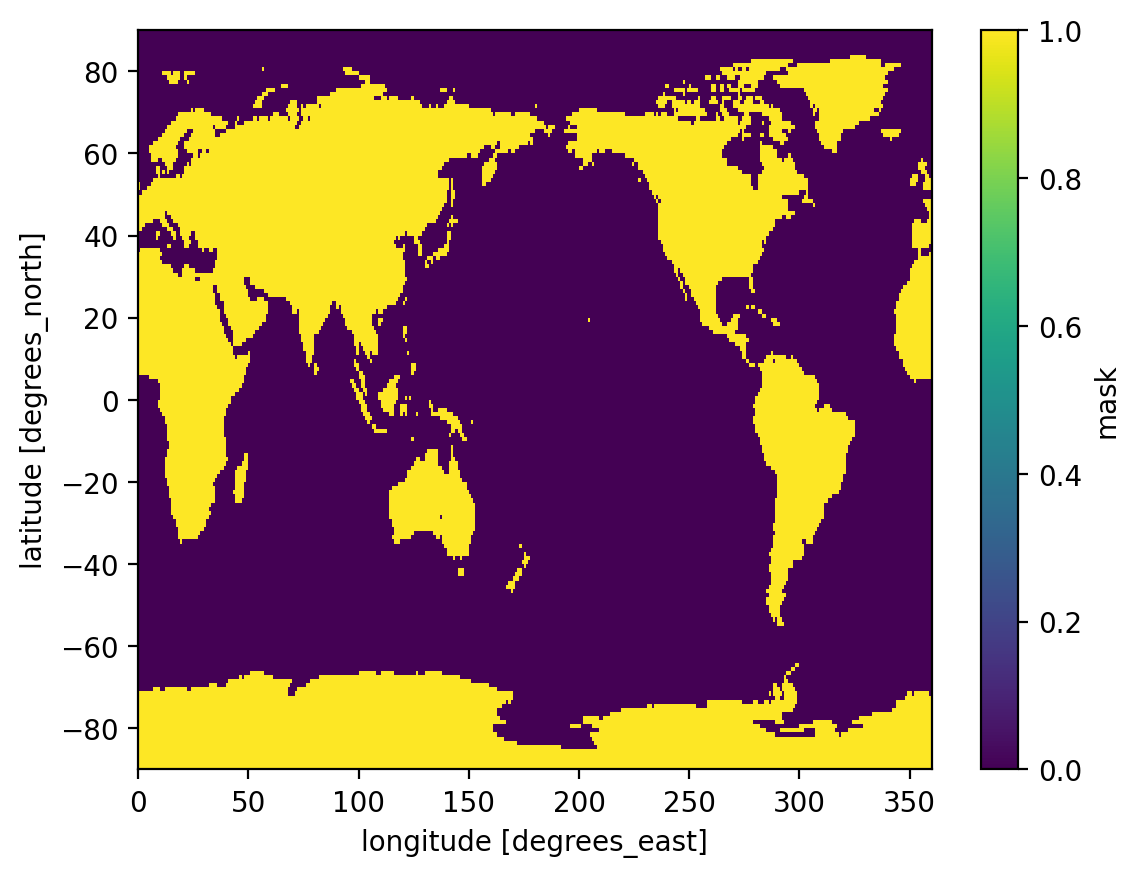

In [12]:
landsea.plot()

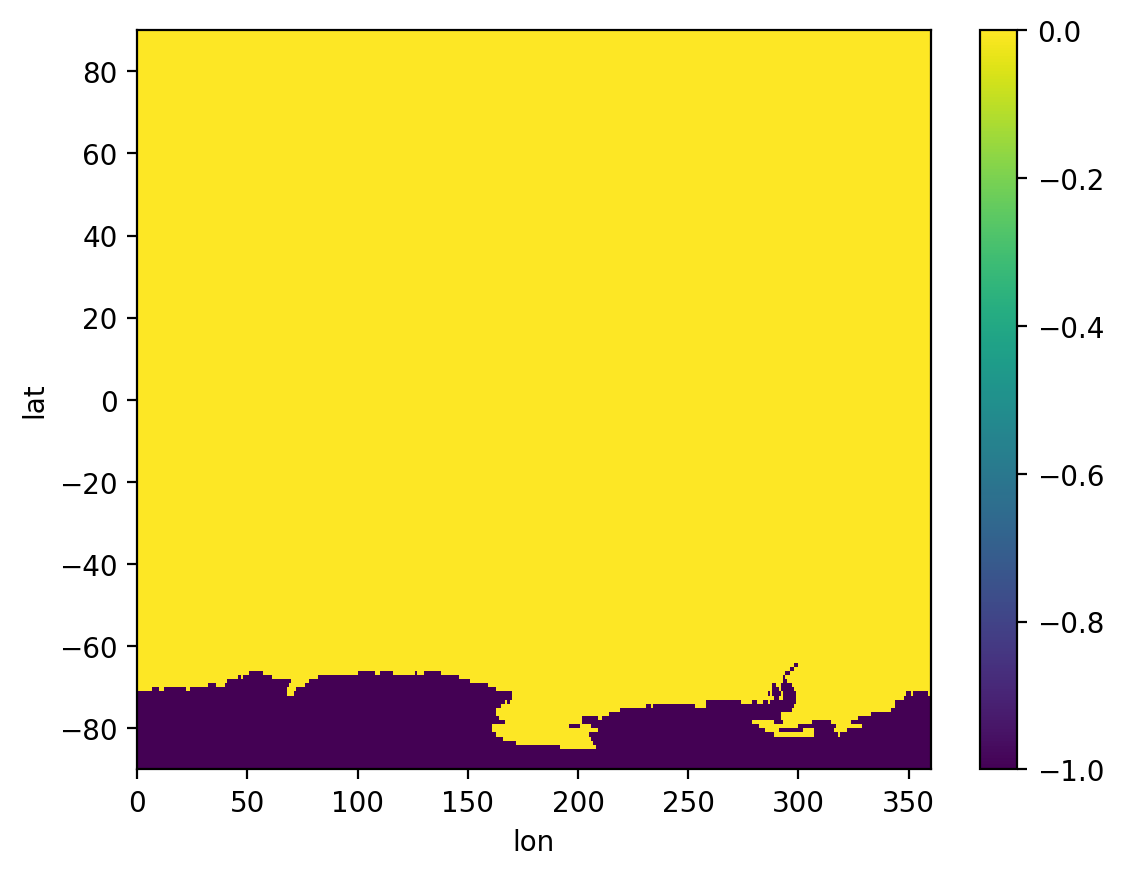

In [13]:
load_aa.plot()

### Compute the associated spherical harmonics and run the sea-level equation

In [14]:
# calculate colatitude in radians
th = (90.0 - load_aa.lat)*np.pi/180.0
LMAX = 360
LOVE = gravtk.load_love_numbers(LMAX)
PLM, dPLM = gravtk.plm_holmes(LMAX, np.cos(th))
LOVE0 = (LOVE[0]-LOVE[0], LOVE[1]-LOVE[1], LOVE[2]-LOVE[2])

In [15]:
# Method 1
# ! This did not work for unknown reason
#
#Ylms = gravtk.gen_harmonics(load_aa.data.T/1000000000000, load_aa.lon.data, load_aa.lat.data, LMAX=LMAX, PLM=PLM)

In [16]:
# Method 2

# Choice of units
#1: cm water equivalent thickness (cm w.e., g/cm2)
#2: gigatonnes of mass (Gt)
#3: mm water equivalent thickness (mm w.e., kg/m2)

Ylms = gravtk.gen_stokes(load_aa.data.T,
    load_aa.lon.data, load_aa.lat.data, UNITS=1,
    LMIN=0, LMAX=LMAX, LOVE=LOVE, PLM=PLM)

Ylms_L0 = gravtk.gen_stokes(load_aa.data.T,
    load_aa.lon.data, load_aa.lat.data, UNITS=1,
    LMIN=0, LMAX=LMAX, LOVE=LOVE0, PLM=PLM)


In [17]:
# Plot the individual harmonics
# yc = xr.DataArray(data=Ylms.clm, 
#                   dims=['x', 'y'],
#                   coords=[np.arange(361), np.arange(361)])

# yc.plot(robust=True)

In [18]:
# sc = xr.DataArray(data=Ylms.slm, 
#                   dims=['x', 'y'],
#                   coords=[np.arange(361), np.arange(361)])

# sc.plot(robust=True)

The function gen_stokes computes the elastic response of the mass change so it is not suited for input data that does not come from GRACE.

In [19]:
rsl = gravtk.sea_level_equation(Ylms.clm, Ylms.slm, load_aa.lon.data, load_aa.lat.data, landsea.data.T,
    LMAX=LMAX, PLM=PLM, LOVE=LOVE, ITERATIONS=6, POLAR=True)

In [20]:
rsl_L0 = gravtk.sea_level_equation(Ylms_L0.clm, Ylms_L0.slm, load_aa.lon.data, load_aa.lat.data, landsea.data.T,
    LMAX=LMAX, PLM=PLM, LOVE=LOVE, ITERATIONS=6, POLAR=True)

In [21]:
rsl_da = xr.DataArray(data=rsl, 
                       dims=['lon', 'lat'],
                      coords=[load_aa.lon.data, load_aa.lat.data])

rsl_L0_da = xr.DataArray(data=rsl_L0, 
                       dims=['lon', 'lat'],
                      coords=[load_aa.lon.data, load_aa.lat.data])

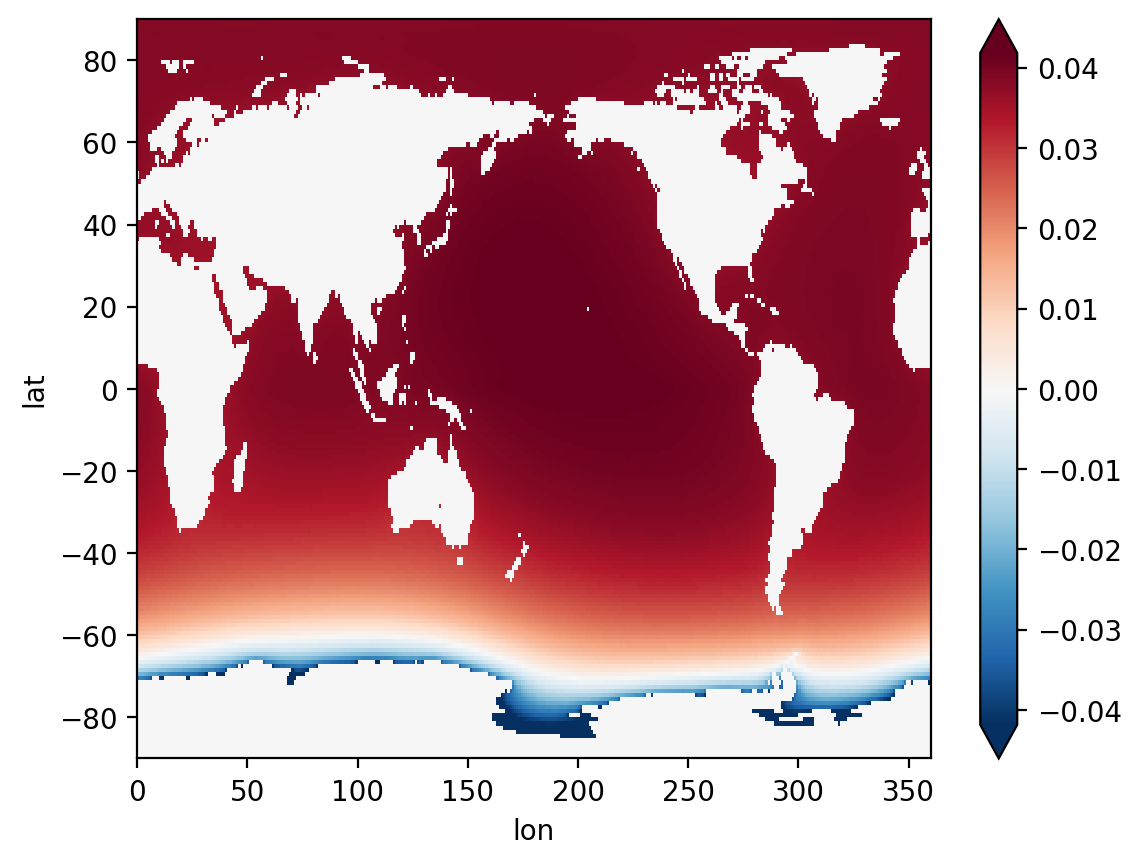

In [22]:
rsl_da.T.plot(robust=True)

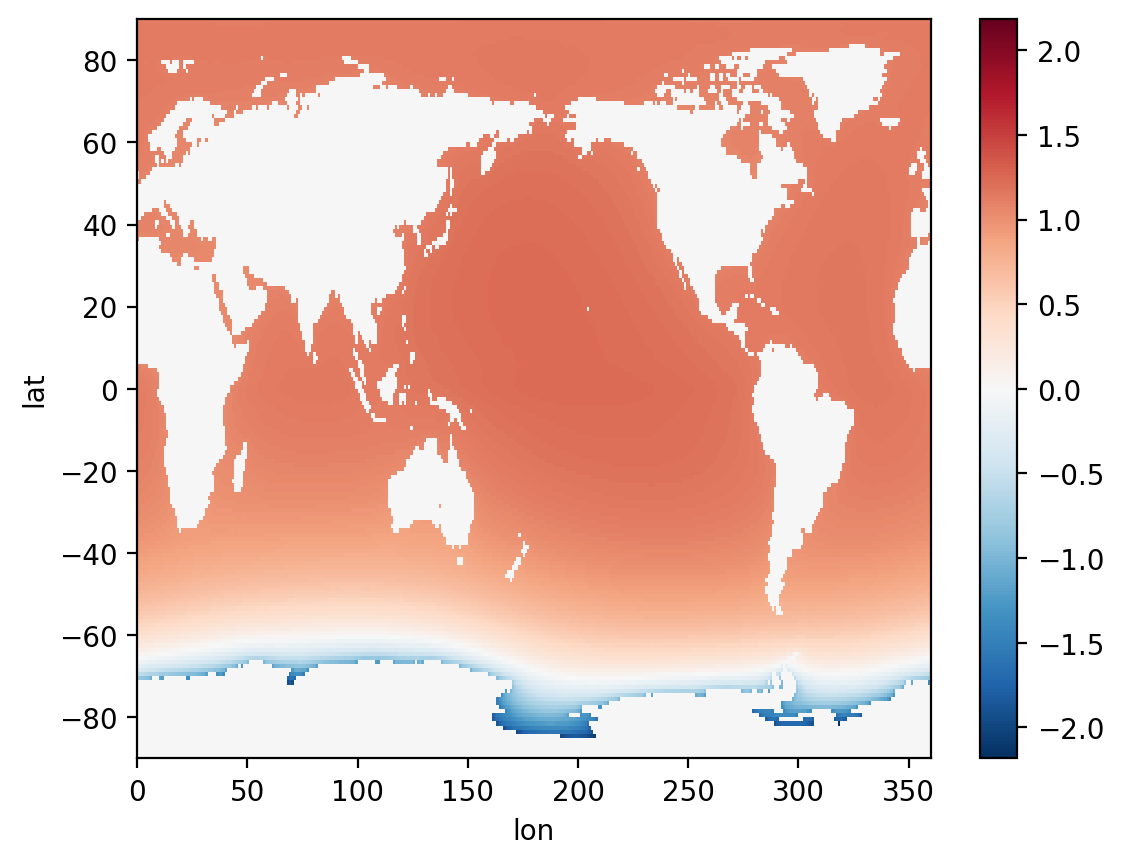

In [35]:
(rsl_da/0.034).T.plot()

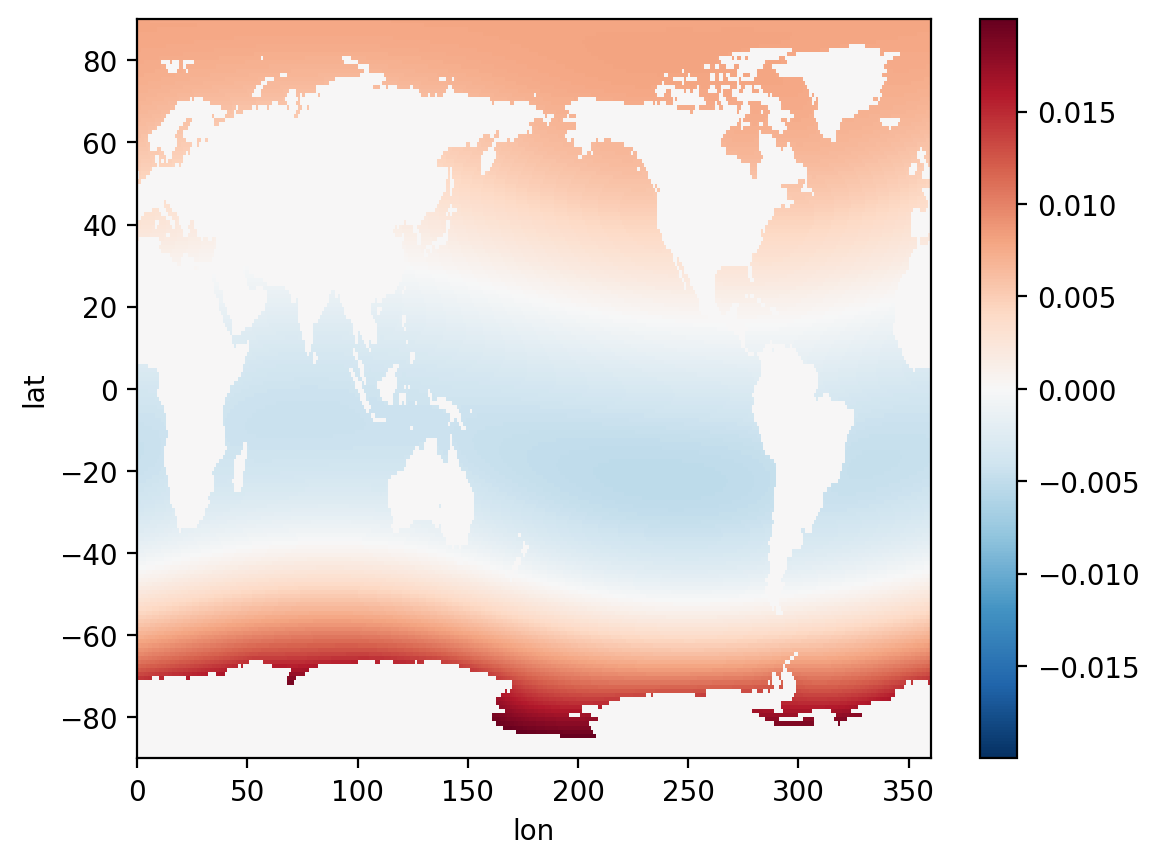

In [23]:
(rsl_da-rsl_L0_da).T.plot()

Is setting the LOVE numbers to 0 the same as including no elastic response?

### Check the mass/volume budget

In [24]:
# Compute the area of each cell

# Get the average radius of the eath [cm]
factors = gravtk.units(lmax=LMAX)
rad_e = factors.rad_e/10**5 # Convert to km

In [25]:
area_da = landsea.copy()
deg2rad = np.pi/180
area_d1 = rad_e**2*np.cos(area_da.lat*deg2rad)*deg2rad**2
area_da.data = area_d1.data[:,np.newaxis]*np.ones(len(area_da.lon))
area_da.name = 'cell area [km**2]'

In [26]:
# Check the computation of the area:

earth_surf_area = 4*np.pi*rad_e**2

print('Analytical computation')
print(earth_surf_area)
print('Sum of grid')
print(area_da.sum().data)

Analytical computation
510064598.40661114
Sum of grid
510071072.40420926


Approximation is not bad

In [27]:
oc_vol_change = area_da*rsl_da

tot_vol_change = oc_vol_change.sum()/10**5
print('Total volume change [km**3]')
print(tot_vol_change.data)

Total volume change [km**3]
124.09291060980476


In [28]:
oc_vol_change_L0 = area_da*rsl_L0_da

tot_vol_change_L0 = oc_vol_change_L0.sum()/10**5
print('Total volume change [km**3]')
print(tot_vol_change_L0.data)

Total volume change [km**3]
124.09291060980473


Compare with the amount of water removed from land

In [29]:
aa_vol_change = area_da*load_aa

oc_sum_vol_change = aa_vol_change.sum()/10**5
print('AA volume change [km**3]')
print(oc_sum_vol_change.data)

AA volume change [km**3]
-124.09291060980465


Average sea level rise for scaling

In [32]:
#! This is not the ocean area
tot_vol_change/area_da.sum()*10**5

<xarray.DataArray ()> Size: 8B
array(0.02432855)

In [33]:
124/360

0.34444444444444444

## What happens if the load change is placed in the water rather than land?

In [284]:
load_oc = xr.DataArray(data=np.zeros([len(load_aa.lat), len(load_aa.lon)]), 
                       dims=['lat', 'lon'],
                      coords=[load_aa.lat.data, load_aa.lon.data])

# or modify a 2D region using xr.where()
mask_oc = (
    (load_oc.coords["lat"] > -10)
    & (load_oc.coords["lat"] < 10)
    & (load_oc.coords["lon"] > 200)
    & (load_oc.coords["lon"] < 230)
)

mask_oc2 = (
    (load_oc.coords["lat"] > 50)
    & (load_oc.coords["lat"] < 55)
    & (load_oc.coords["lon"] > 195)
    & (load_oc.coords["lon"] < 205)
)

mask_oc3 = (
    (load_oc.coords["lat"] > 49)
    & (load_oc.coords["lat"] < 56)
    & (load_oc.coords["lon"] > 194)
    & (load_oc.coords["lon"] < 206)
)

mask_oc4 = (
    (load_oc.coords["lat"] > 48)
    & (load_oc.coords["lat"] < 57)
    & (load_oc.coords["lon"] > 193)
    & (load_oc.coords["lon"] < 207)
)

load_oc = xr.where(mask_oc4, 0.3, load_oc)
load_oc = xr.where(mask_oc3, 0.7, load_oc)
load_oc = xr.where(mask_oc2, 1, load_oc)


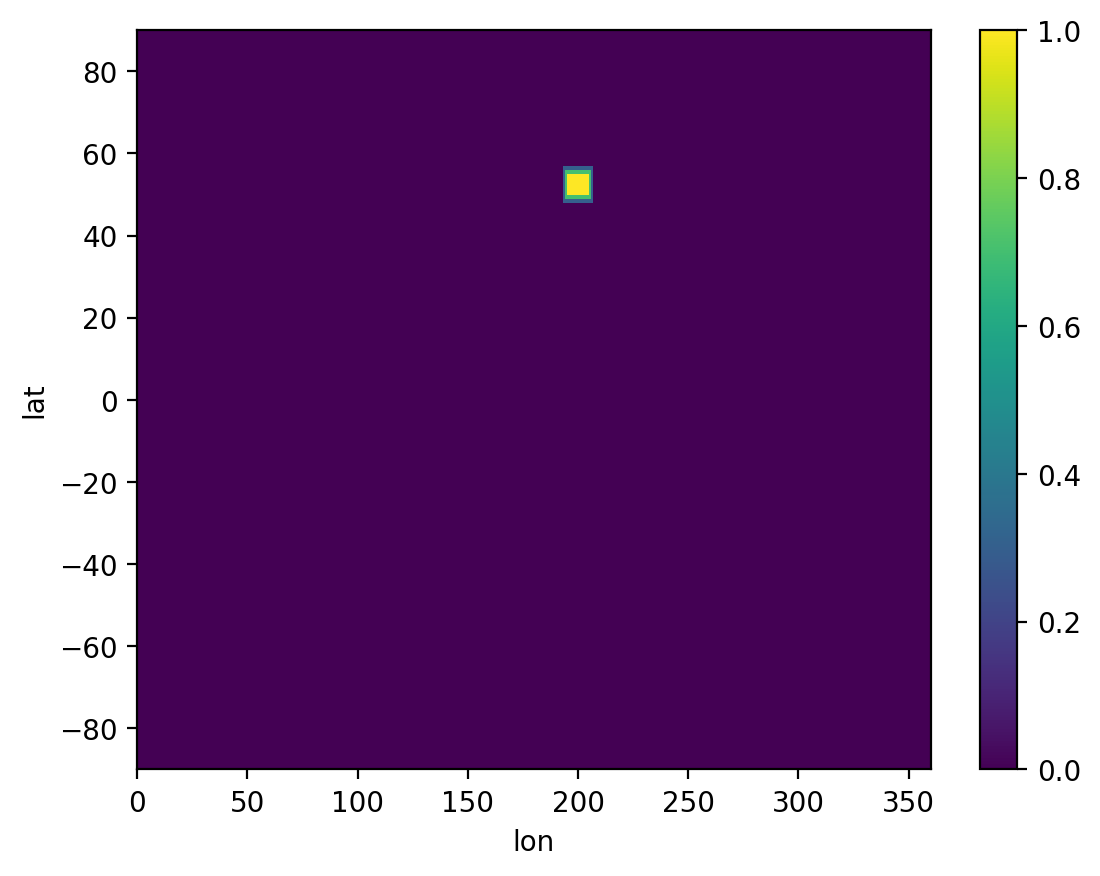

In [285]:
load_oc.plot()

In [286]:
LMAX2 = 360
LOVE = gravtk.load_love_numbers(LMAX2)
PLM, dPLM = gravtk.plm_holmes(LMAX2, np.cos(th))
LOVE0 = (LOVE[0]-LOVE[0], LOVE[1]-LOVE[1], LOVE[2]-LOVE[2])
Ylms_oc = gravtk.gen_stokes(load_oc.data.T,
    load_oc.lon.data, load_oc.lat.data, UNITS=1,
    LMIN=0, LMAX=LMAX2, LOVE=LOVE0, PLM=PLM)

In [287]:
rsl_oc = gravtk.sea_level_equation(Ylms_oc.clm, Ylms_oc.slm, load_oc.lon.data, load_oc.lat.data, landsea.data.T,
    LMAX=LMAX2, PLM=PLM, LOVE=LOVE, ITERATIONS=6, POLAR=True)

In [288]:
rsl_oc_da = xr.DataArray(data=rsl_oc, 
                       dims=['lon', 'lat'],
                      coords=[load_oc.lon.data, load_oc.lat.data])

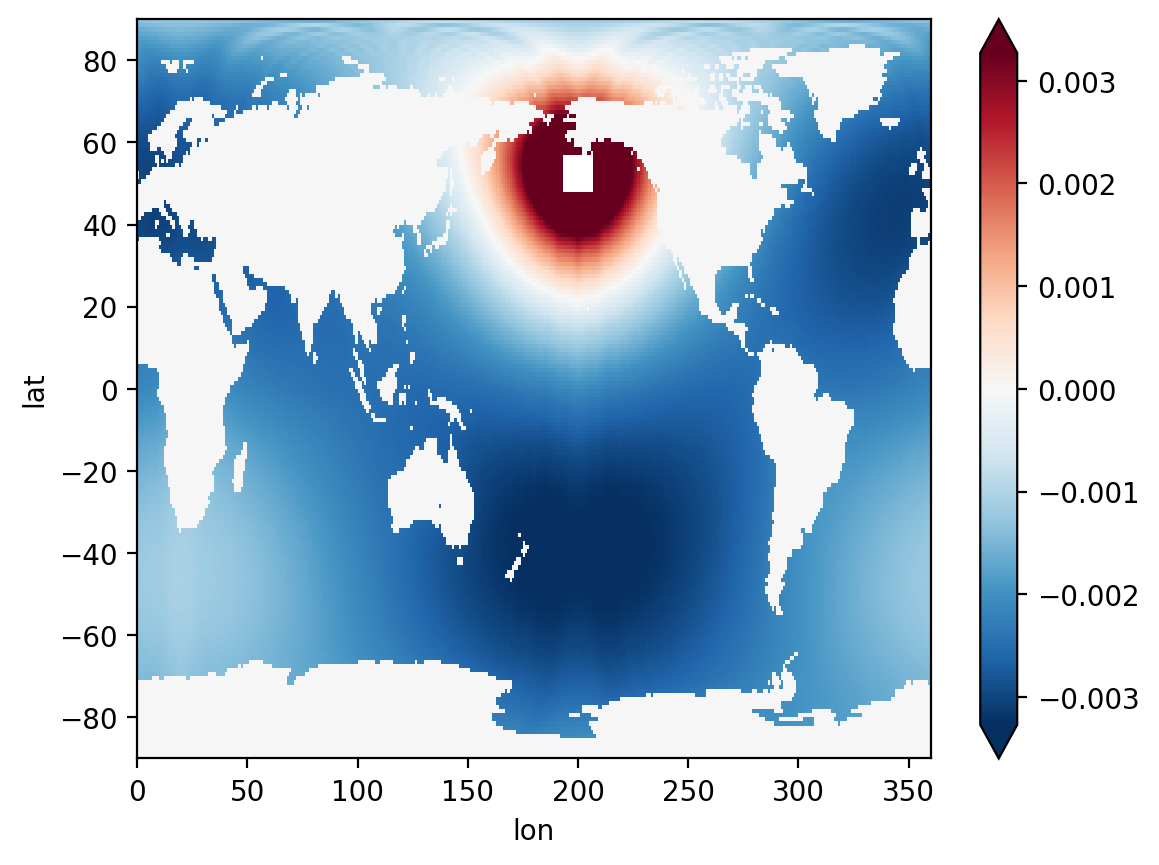

In [290]:
rsl_oc_da = xr.where(mask_oc4, np.nan, rsl_oc_da)
rsl_oc_da.plot(robust=True)

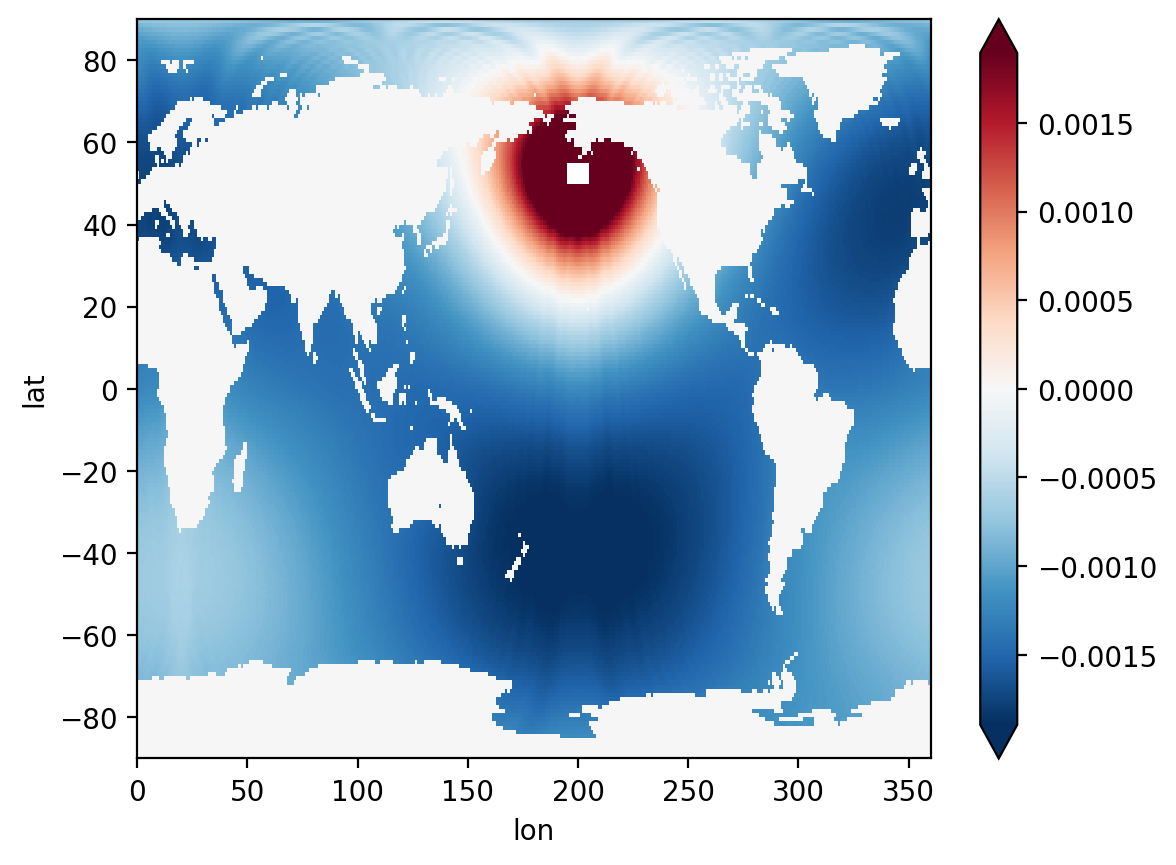

In [269]:
rsl_oc_da = xr.where(mask_oc2, np.nan, rsl_oc_da)
rsl_oc_da.plot(robust=True)

In [247]:
oc_vol_change = area_da*rsl_oc_da

tot_vol_change = oc_vol_change.sum()/10**5
print('Total volume change [km**3]')
print(tot_vol_change.data)

Total volume change [km**3]
-73.81076016967317


In [249]:
load_oc_vol_change = area_da*load_oc

load_oc_sum_vol_change = load_oc_vol_change.sum()/10**5
print('AA volume change [km**3]')
print(load_oc_sum_vol_change.data)

AA volume change [km**3]
73.81076016967317


### Questions

Why does gen_stokes need the load numbers? It should simply be projecting a spatial field into a spherical harmonic space.

This is because it takes into account the earth elastic response. The mass change is as seen from satellite.